In [2]:
# This is the template for the submission. If you want, you can develop your algorithm in a regular Python script and copy the code here for submission.

# Team members (e-mail, legi):
# chozhang@student.ethz.ch, 22-945-562
# minghli@student.ethz.ch, 22-953-293
# changli@student.ethz.ch, 22-944-474

In [3]:
from typing import Sequence

In [4]:
import os
import sys
curr_environ = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')
if curr_environ != 'Localhost': 
    sys.path.append('/kaggle/input/mobile-health-2023-path-detection')
    input_dir = '/kaggle/input/mobile-health-2023-path-detection'
else:
    input_dir = os.path.abspath('')

In [5]:
import numpy as np
import pandas as pd

from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset
from os import listdir
from os.path import isfile, join

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
import matplotlib.pyplot as plt

In [7]:
# for signal processing and calculations
from scipy import signal

# for tuning parameters
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

In [100]:
### signal processing functions ###
def parse(signal, ds_freq:float=20.0, zero_mean:bool=False):
    """downsampling the signal to specific frequency ds_freq, and make the data
     with zero mean if zero_mean is True"""
    ori_time_seq = np.array(signal.timestamps)
    ori_value_seq = np.array(signal.values)
    if zero_mean: ori_value_seq = ori_value_seq - np.mean(ori_value_seq)
    dt = 1./ds_freq
    time_seq = np.arange(start=np.min(ori_time_seq), stop=np.max(ori_time_seq), step=dt)
    value_seq = np.interp(time_seq, ori_time_seq, ori_value_seq)
    return time_seq, value_seq
    
def bp_filter(value_seq, fp:float=3, fs:float=20.0):
    """apply band pass filter to the sequence. fp is the threshold frequency,
     and fs is the sampling frequency."""
    sos = signal.butter(N=4, Wn=[0.5,fp], btype='bandpass', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, value_seq)
    return filtered

def lp_filter(value_seq, window=100):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a = np.convolve(value_seq, weights, mode='full')[:len(value_seq)]
    a[:window] = a[window]
    return a
    
def get_envelop(value_seq, 
                fs:float=20, 
                half_window_size:float=0.5, 
                _min:float=20., 
                _max:float=500.):
    """
    get the envelop as the adaptive local norm of the signal, currently the mode
     of vector (no negative values). The envelop is calculated by the maximum in
     a window, half_window_size is the seconds of time. _min and _max for clip.
    """
    half_win = int(fs*half_window_size)
    seq = np.concatenate([np.zeros((half_win,)),value_seq,np.zeros((half_win,))])
    envelop = np.array([np.max(seq[k-half_win:k+half_win+1]) 
                        for k in range(half_win,half_win+len(value_seq))])
    return np.clip(envelop, _min, _max)

# Tasks

## Step Count

---

## Smart Watch Location

---

## Path Index

All traces must contain GPS data, so can use this for sanity check.

In [137]:
class PathDetector(BaseEstimator):
    # hack labels via GPS, delete later
    def __init__(self):
        pass

    # required
    def fit(self, data, labels):
        pass

    # required    
    def predict(self, traces):
        # assume array
        if hasattr(traces, '__len__'):
            res = np.zeros(len(traces), dtype=int)
            _traces = traces
        else:
            res = np.zeros(1, dtype=int)
            _traces = [traces]
        i = 0
        for trace in _traces:
            data = trace.data
            # gps data
            alti = data['altitude']
            t, alti = parse(alti)
            t = t[600:]
            alti = alti[600:]
            alti = lp_filter(alti, window=400)
            alti = alti - np.min(alti)
            alti[alti>60] = 60
            t = (t - np.min(t)) / (np.max(t) - np.min(t))
            plt.plot(t, alti)
            
            
            
            res[i] = 0
            i += 1
        if len(res) == 1:
            return res[0]
        else:
            return res

1


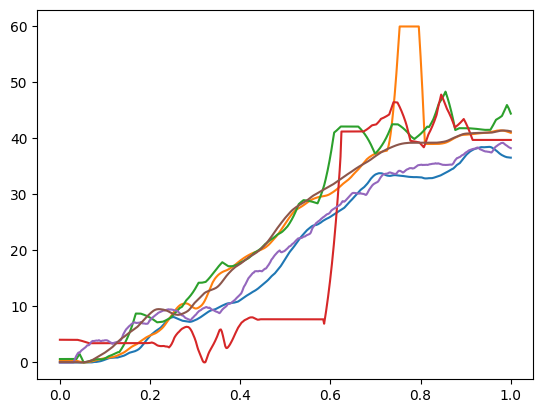

In [140]:
dec = PathDetector()
for f in range(30):
    if labels[f]==1:
        trace = Recording(filenames[f], no_labels=False, mute=True)
        _ = dec.predict(trace)
print(trace.labels['path_idx'])

In [111]:
dir_traces = '/kaggle/input/mobile-health-2023-path-detection/data/train'
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
filenames.sort()
labels = []
for f in filenames[:30]:
    print(f)
    trace = Recording(f, no_labels=False, mute=True)
    labels.append(trace.labels['path_idx'])
print(labels)

/kaggle/input/mobile-health-2023-path-detection/data/train/train_trace_001.json
/kaggle/input/mobile-health-2023-path-detection/data/train/train_trace_002.json
/kaggle/input/mobile-health-2023-path-detection/data/train/train_trace_003.json
/kaggle/input/mobile-health-2023-path-detection/data/train/train_trace_004.json
/kaggle/input/mobile-health-2023-path-detection/data/train/train_trace_005.json
/kaggle/input/mobile-health-2023-path-detection/data/train/train_trace_006.json
/kaggle/input/mobile-health-2023-path-detection/data/train/train_trace_007.json
/kaggle/input/mobile-health-2023-path-detection/data/train/train_trace_008.json
/kaggle/input/mobile-health-2023-path-detection/data/train/train_trace_009.json
/kaggle/input/mobile-health-2023-path-detection/data/train/train_trace_010.json
/kaggle/input/mobile-health-2023-path-detection/data/train/train_trace_011.json
/kaggle/input/mobile-health-2023-path-detection/data/train/train_trace_012.json
/kaggle/input/mobile-health-2023-path-de

---

## Activity

Activities contained in the data trace and performed for more than 60 s uninterrupted. 

Output as a list of integers: e.g., `[0, 3]` (`0`: standing still, `1`: walk, `2`: run, `3`: cycle). 

These do not need to be in the right order and they do not need to occur multiple times.

In [17]:
class ActivityPredictor(BaseEstimator):
    # required
    def __init__(self):
        pass

    # required
    def fit(self, data, labels):
        pass

    # required
    def predict(self, trace):
        pass

---

# Prediction

In [10]:
# Get the path of all traces
dir_traces = '/kaggle/input/mobile-health-2023-path-detection/data/test'
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
filenames.sort()

In [19]:
# initialize predictors
step_counter = StepCounter()

In [20]:
# Loop through all traces and calculate the step count for each trace
solution_file = []
for filename in filenames:
    trace = Recording(filename, no_labels=True, mute=True)
    categorization_results = {'watch_loc': 114514, 'path_idx': 0, 'step_count': 1919810, 'stand': 114514, 'walk': 114514, 'run': 114514, 'cycle': 114514}

    #
    # Your algorithm goes here
    # You can access the variable 'watch_loc' in the dictionary 'categorization_results' for example with
    # categorization_results['watch_loc'] = 1
    # Make sure, you do not use the gps data and are tolerant for missing data (see task set).
    # Your program must not crash when single smartphone data traces are missing.
    #
    categorization_results['step_count'] = step_counter.predict(trace)

    # Append your calculated results and the id of each trace and category to the solution file
    trace_id = ''.join([*filename][-8:-5])
    for counter_label, category in enumerate(categorization_results):
        solution_file.append([trace_id + f'_{counter_label+1}', categorization_results[category]])


In [21]:
# Write the detected step counts into a .csv file to then upload the .csv file to Kaggle
# When cross-checking the .csv file on your computer, we recommend using the text editor and NOT excel so that the results are displayed correctly
# IMPORTANT: Do NOT change the name of the columns ('Id' and 'Category') of the .csv file
submission_file_df = pd.DataFrame(np.asarray(solution_file), columns=['Id', 'Category'])
submission_file_df.to_csv('/kaggle/working/submission.csv', header=['Id', 'Category'], index=False)